In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import tensorflow as tf
import edward as ed
from edward.models import Normal
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-talk')
sns.set_context("talk", font_scale=1.4)
sess = ed.get_session()
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Activation
from keras.optimizers import Nadam

# Data
-----------------

## Data Ingestion

In our project, we will use [Turbofan Engine Degradation Simulation Data Set](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan) provided by NASA. It has 26 columns. The first is the `id`, which is an identification of a single turbofan. The second is the `cycle`, which is the timestamp starts from 1 when a turbofan start to run. The remaining 24 columns contain 3 `settings` and 21 `sensor readings` of the turbofan at that timestamp. When a turbofan breaks down, the record of that turbofan will end. Our goal is to predict when the remaining useful life(RUL) of each turbofan, so we first create a column called `RUL`, for each turbofan id, `RUL` is the remaining time until this turbofan breaks down, which is our target variable. Then we normalized the `cycle`, 3 `settings` and 21 `sensor readings` using min-max scaler. We will use this 25 variables as feature set.

In [2]:
# read training data, test data and groud truth data for test data
train_df = pd.read_csv('CMAPSSData/train_FD001.txt', sep=" ", header=None)
test_df = pd.read_csv('CMAPSSData/test_FD001.txt', sep=" ", header=None)
truth_df = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep=" ", header=None)

In [3]:
# preprocesse the data as described
from util import turbo_preprocessing
train_df, test_df = turbo_preprocessing(train_df,test_df,truth_df)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0.01108


In [4]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0.01108


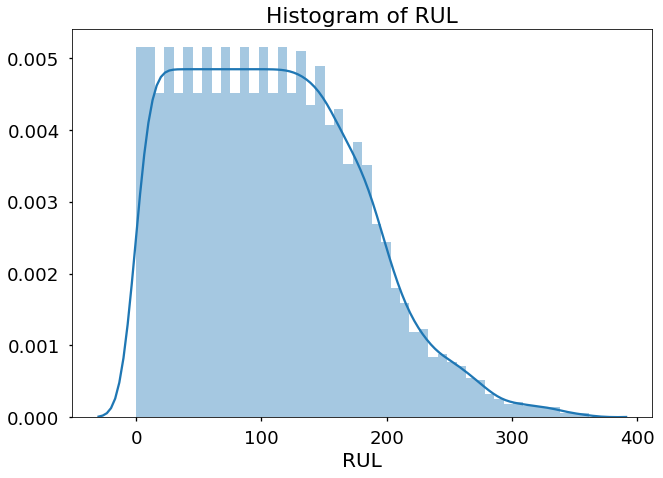

In [5]:
sns.distplot(train_df.RUL)
plt.title('Histogram of RUL')
plt.xlabel('RUL');

## Data Sequencing

In order to fit our data into an Recurrent Neural Network(RNN) setting, we have to turn our data into sequences. First we have to choose the sequence length, which determines how many previous information we want to include in our RNN, which is also the length of RNN. Here we pick sequence length of 5, since it already works well and do not require lots of time to do the inference. Then we generate the sequence of features and labels based on this number. We will split our data into 10% training and 90% validation since the inference step will take a lot of time on large data. Later on we will extend the training-validation ratio to 90:10.

In [6]:
# pick a window size of 5 cycles
sequence_length = 5

In [7]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [8]:
# generator for the sequences
from util import gen_sequence
seq_gen = [list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique()]

In [9]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(seq_gen).astype(np.float32)
seq_array.shape

(20131, 5, 25)

In [10]:
# generate labels
from util import gen_labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.squeeze(np.concatenate(label_gen).astype(np.float32))
label_array.shape

(20131,)

In [11]:
seq_array1,seq_array2,label_array1,label_array2 = train_test_split(seq_array,label_array,test_size=0.9,shuffle=False)

In [12]:
H = 100  # number of hidden units
N,_,D = seq_array1.shape  # number of training data points, number of features
print(f'Number of hidden units is {H},\nNumber of training data points is {N},\nLength of sequence is {sequence_length},\nNumber of features is {D}')

Number of hidden units is 100,
Number of training data points is 2013,
Length of sequence is 5,
Number of features is 25


# Modeling, Black Box Variational Inference and Critisism

In this part, we will explore different neural network models, each with frequentist(least mean squared error) and Bayesian inference(black box variational inference). We want to make comparisons of the result in two directions: first is the comparison between frequentist and Bayesian inference, and the second is the comparison between different model structures. The comparisons will be based on both theoretical knowledge and model critisism.

## 1.Fully conected layers

First, we will not use RNN structure but fully conected layers to build a baseline model. We want to know that how well the prediction will be if we do not include information from previous cycle. The network contains one hidden layer with hyperbolic tangent activation and output layer with linear activation. 

In [56]:
model = Sequential()

model.add(Dense(10,
         input_shape=[D],activation='tanh'))

model.add(Dense(units=1))
nadam = Nadam(lr=0.05)
model.compile(loss='mean_squared_error', optimizer=nadam, metrics=['mean_squared_error'])
model.fit(seq_array1[:,sequence_length-1,:], label_array1, epochs=300, batch_size=200, 
          validation_data=(seq_array2[:,sequence_length-1,:],label_array2), verbose=0)

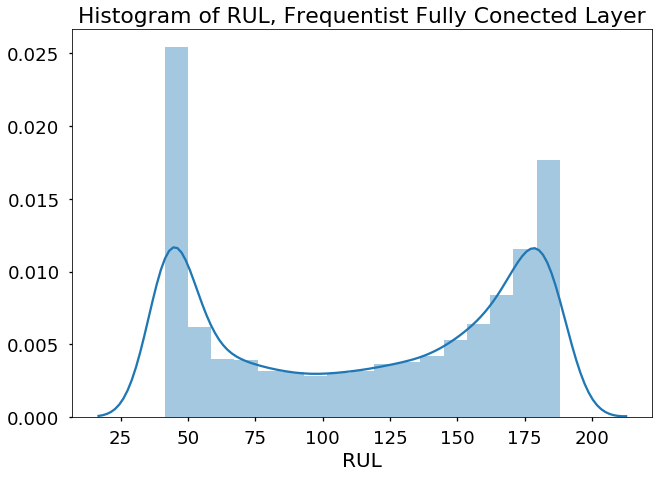

In [57]:
y_pred = np.squeeze(model.predict(seq_array2[:,sequence_length-1,:]))
sns.distplot(y_pred)
plt.title('Histogram of RUL, Frequentist Fully Conected Layer')
plt.xlabel('RUL');

In [58]:
print(f'Validation RMSE: {np.sqrt(mean_squared_error(label_array2,y_pred))}')

Validation RMSE: 42.59910202026367


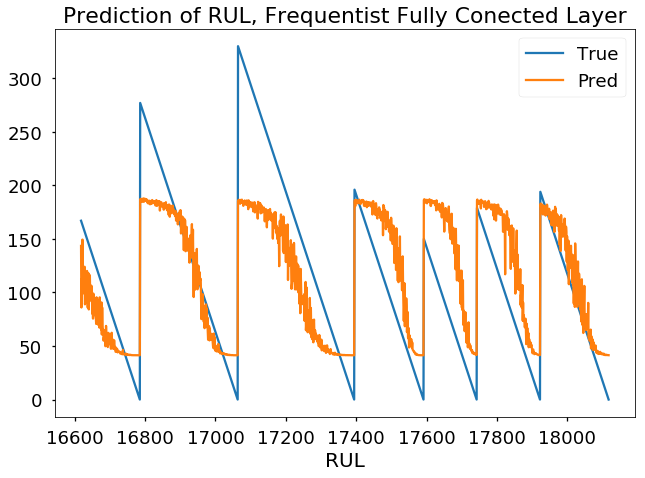

In [64]:
pd.DataFrame([label_array2,y_pred]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Frequentist Fully Conected Layer')
plt.xlabel('RUL');

In [41]:
def neural_network_with_2_layers(x, W_0, W_1, b_0, b_1):
    h = tf.nn.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

dim = 10  # layer dimensions

W_0 = Normal(loc=tf.zeros([D, dim]),
             scale=tf.ones([D, dim]))
W_1 = Normal(loc=tf.zeros([dim, 1]),
             scale=tf.ones([dim, 1]))
b_0 = Normal(loc=tf.zeros(dim),
             scale=tf.ones(dim))
b_1 = Normal(loc=tf.zeros(1),
             scale=tf.ones(1))

x = tf.placeholder(tf.float32, [N, D])
y = Normal(loc=neural_network_with_2_layers(x, W_0, W_1, b_0, b_1),
           scale=tf.ones(N) * 0.1)  # constant noise

In [42]:
# BACKWARD MODEL A
q_W_0 = Normal(loc=tf.Variable(tf.random_normal([D, dim])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, dim]))))
q_W_1 = Normal(loc=tf.Variable(tf.random_normal([dim, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim, 1]))))
q_b_0 = Normal(loc=tf.Variable(tf.random_normal([dim])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim]))))
q_b_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [43]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={W_0: q_W_0, b_0: q_b_0,
                                 W_1: q_W_1, b_1: q_b_1},
                    data={x: seq_array1[:,sequence_length-1,:], y: label_array1})
inference.run(n_samples=5,n_iter=25000)

25000/25000 [100%] ██████████████████████████████ Elapsed: 42s | Loss: 58088260.000


In [44]:
xp = tf.placeholder(tf.float32,seq_array2[:,sequence_length-1,:].shape)

In [50]:
y_preds = [sess.run(neural_network_with_2_layers(xp,q_W_0, q_W_1,q_b_0, q_b_1),{xp:seq_array2[:,sequence_length-1,:]})
          for _ in range(50)]

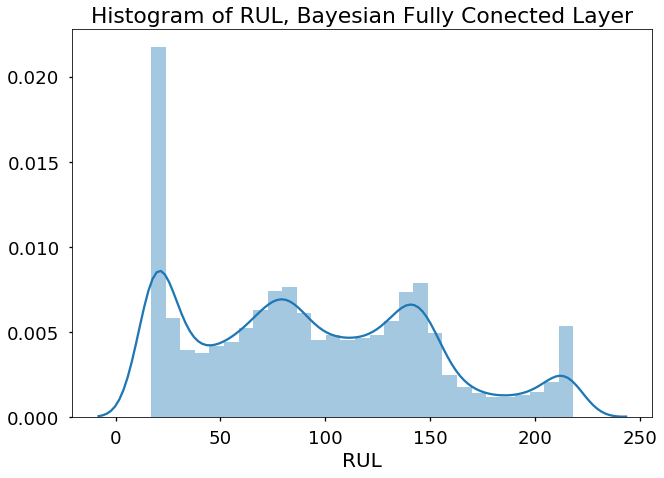

In [51]:
sns.distplot(y_preds[0])
plt.title('Histogram of RUL, Bayesian Fully Conected Layer')
plt.xlabel('RUL');

In [62]:
print(f'Average Validation RMSE: {np.mean([np.sqrt(mean_squared_error(label_array2,y_pred)) for y_pred in y_preds])}')

Average Validation RMSE: 42.597190856933594


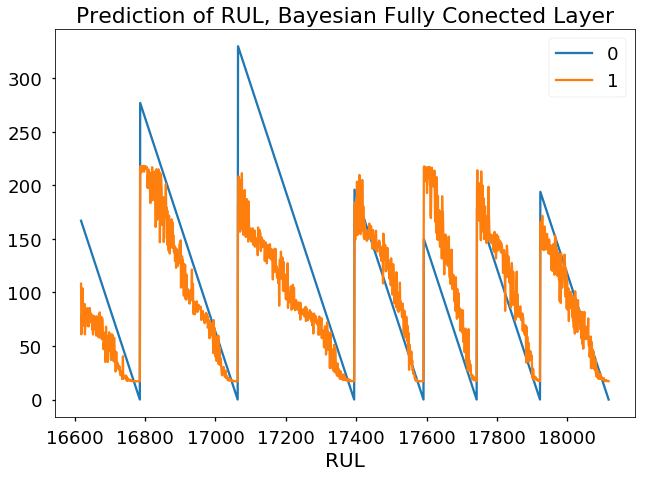

In [65]:
pd.DataFrame([label_array2,y_preds[0]]).transpose()[-1500:].plot()
plt.title('Prediction of RUL, Bayesian Fully Conected Layer')
plt.xlabel('RUL');

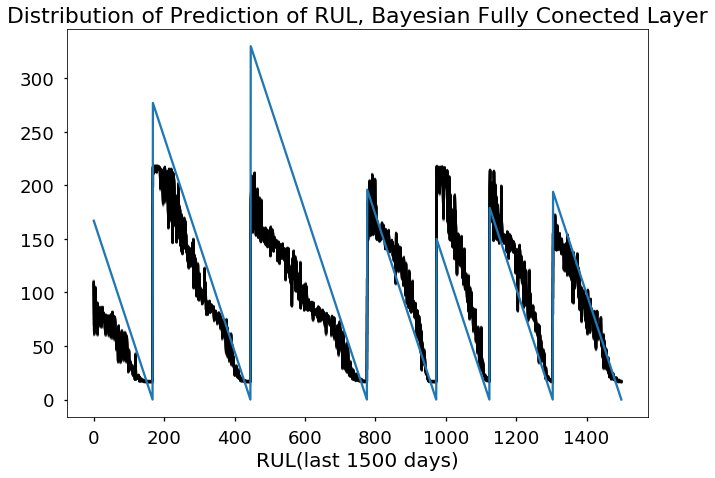

In [72]:
[plt.plot(y_pred[-1500:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-1500:])
plt.title('Distribution of Prediction of RUL, Bayesian Fully Conected Layer')
plt.xlabel('RUL(last 1500 days)');

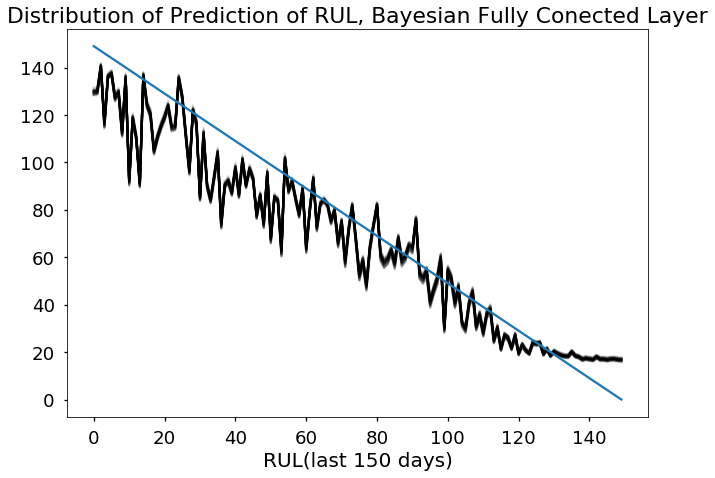

In [73]:
[plt.plot(y_pred[-150:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-150:])
plt.title('Distribution of Prediction of RUL, Bayesian Fully Conected Layer')
plt.xlabel('RUL(last 150 days)');

**First**, we can see that RMSE can not truely represent the goodness of fit in this setting. The frequentist and Bayesian inference has very similar RMSE, but the visualization shows Bayesian inference gets much better results than frequentist. So in the later model critisism we will mainly focus on the visualization.  
**Second**, because of the nature of this data set, it may be harder to predict large RUL than small RUL. For example, turbofan at 200 cycle before breakdown may have very similar feature set values with turbofan at 150 cycle because it has not yet started degradation, but feature set at cycle 50 may be very different with that at cycle 1. In addition, we care more about the smaller values of RUL. It does not matter so much it is 200 days or 150 days until the turbofan breaks down, but it matters very much if the RUL is small because this is time we want to send technician to fix the turbofan. So we will think models that performs well in the smaller range of RUL is better. Clearly both of the models are not good, the Bayesian approach one is slightly better.  
**Third**, the purpose of using Bayesian inference is to get a distribution at each prediction point, in order to get the confidence level. We expect the point that are not accurately predicted will have higher variance. However, in this model, this is not the case.

## RNN
-------------------

In [32]:
model = Sequential()

model.add(SimpleRNN(
         input_shape=(sequence_length, D),
         units=H))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error'])
model.fit(seq_array1, label_array1, epochs=300, batch_size=200, 
          validation_data=(seq_array2,label_array2), verbose=1)

Train on 2013 samples, validate on 18118 samples
Epoch 1/300
2013/2013 [==============================] - 1s 308us/step - loss: 15599.5197 - mean_squared_error: 15599.5197 - val_loss: 13519.8909 - val_mean_squared_error: 13519.8909
Epoch 2/300
2013/2013 [==============================] - 0s 126us/step - loss: 14202.4206 - mean_squared_error: 14202.4206 - val_loss: 12786.4674 - val_mean_squared_error: 12786.4674
Epoch 3/300
2013/2013 [==============================] - 0s 124us/step - loss: 13562.5076 - mean_squared_error: 13562.5076 - val_loss: 12293.8972 - val_mean_squared_error: 12293.8972
Epoch 4/300
2013/2013 [==============================] - 0s 127us/step - loss: 13067.8287 - mean_squared_error: 13067.8287 - val_loss: 11863.0066 - val_mean_squared_error: 11863.0066
Epoch 5/300
2013/2013 [==============================] - 0s 125us/step - loss: 12622.4445 - mean_squared_error: 12622.4445 - val_loss: 11459.2728 - val_mean_squared_error: 11459.2728
Epoch 6/300
2013/2013 [=============

2013/2013 [==============================] - 0s 123us/step - loss: 3862.9145 - mean_squared_error: 3862.9145 - val_loss: 3694.0884 - val_mean_squared_error: 3694.0884
Epoch 47/300
2013/2013 [==============================] - 0s 121us/step - loss: 3763.3485 - mean_squared_error: 3763.3485 - val_loss: 3828.7183 - val_mean_squared_error: 3828.7183
Epoch 48/300
2013/2013 [==============================] - 0s 119us/step - loss: 3670.4870 - mean_squared_error: 3670.4870 - val_loss: 3563.3654 - val_mean_squared_error: 3563.3654
Epoch 49/300
2013/2013 [==============================] - 0s 136us/step - loss: 3563.8575 - mean_squared_error: 3563.8575 - val_loss: 3531.0783 - val_mean_squared_error: 3531.0783
Epoch 50/300
2013/2013 [==============================] - 0s 119us/step - loss: 3474.3752 - mean_squared_error: 3474.3752 - val_loss: 3378.7592 - val_mean_squared_error: 3378.7592
Epoch 51/300
2013/2013 [==============================] - 0s 119us/step - loss: 3377.4140 - mean_squared_error: 3

2013/2013 [==============================] - 0s 123us/step - loss: 885.4983 - mean_squared_error: 885.4983 - val_loss: 1769.6252 - val_mean_squared_error: 1769.6252
Epoch 137/300
2013/2013 [==============================] - 0s 122us/step - loss: 875.0925 - mean_squared_error: 875.0925 - val_loss: 1889.2823 - val_mean_squared_error: 1889.2823
Epoch 138/300
2013/2013 [==============================] - 0s 123us/step - loss: 880.6587 - mean_squared_error: 880.6587 - val_loss: 2272.6113 - val_mean_squared_error: 2272.6113
Epoch 139/300
2013/2013 [==============================] - 0s 127us/step - loss: 878.6106 - mean_squared_error: 878.6106 - val_loss: 1668.2469 - val_mean_squared_error: 1668.2469
Epoch 140/300
2013/2013 [==============================] - 0s 129us/step - loss: 880.8858 - mean_squared_error: 880.8858 - val_loss: 1760.1539 - val_mean_squared_error: 1760.1539
Epoch 141/300
2013/2013 [==============================] - 0s 130us/step - loss: 867.7222 - mean_squared_error: 867.722

Epoch 182/300
2013/2013 [==============================] - 0s 122us/step - loss: 710.3984 - mean_squared_error: 710.3984 - val_loss: 2046.3102 - val_mean_squared_error: 2046.3102
Epoch 183/300
2013/2013 [==============================] - 0s 131us/step - loss: 662.8502 - mean_squared_error: 662.8502 - val_loss: 1835.9578 - val_mean_squared_error: 1835.9578
Epoch 184/300
2013/2013 [==============================] - 0s 126us/step - loss: 617.2511 - mean_squared_error: 617.2511 - val_loss: 1661.1121 - val_mean_squared_error: 1661.1121
Epoch 185/300
2013/2013 [==============================] - 0s 128us/step - loss: 617.7858 - mean_squared_error: 617.7858 - val_loss: 1974.6513 - val_mean_squared_error: 1974.6513
Epoch 186/300
2013/2013 [==============================] - 0s 124us/step - loss: 592.5030 - mean_squared_error: 592.5030 - val_loss: 1481.2451 - val_mean_squared_error: 1481.2451
Epoch 187/300
2013/2013 [==============================] - 0s 127us/step - loss: 627.6426 - mean_squared_

Epoch 228/300
2013/2013 [==============================] - 0s 124us/step - loss: 476.2956 - mean_squared_error: 476.2956 - val_loss: 1561.5555 - val_mean_squared_error: 1561.5555
Epoch 229/300
2013/2013 [==============================] - 0s 122us/step - loss: 504.4297 - mean_squared_error: 504.4297 - val_loss: 2157.3900 - val_mean_squared_error: 2157.3900
Epoch 230/300
2013/2013 [==============================] - 0s 124us/step - loss: 493.9907 - mean_squared_error: 493.9907 - val_loss: 1970.8894 - val_mean_squared_error: 1970.8894
Epoch 231/300
2013/2013 [==============================] - 0s 127us/step - loss: 473.0297 - mean_squared_error: 473.0297 - val_loss: 1851.7361 - val_mean_squared_error: 1851.7361
Epoch 232/300
2013/2013 [==============================] - 0s 125us/step - loss: 462.2442 - mean_squared_error: 462.2442 - val_loss: 1731.5491 - val_mean_squared_error: 1731.5491
Epoch 233/300
2013/2013 [==============================] - 0s 135us/step - loss: 469.9700 - mean_squared_

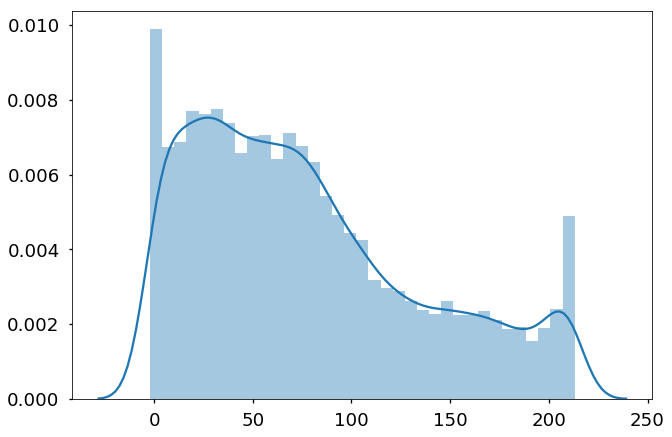

In [33]:
y_pred = np.squeeze(model.predict(seq_array2))
sns.distplot(y_pred)

In [34]:
np.sqrt(mean_squared_error(label_array2,y_pred))

51.374756

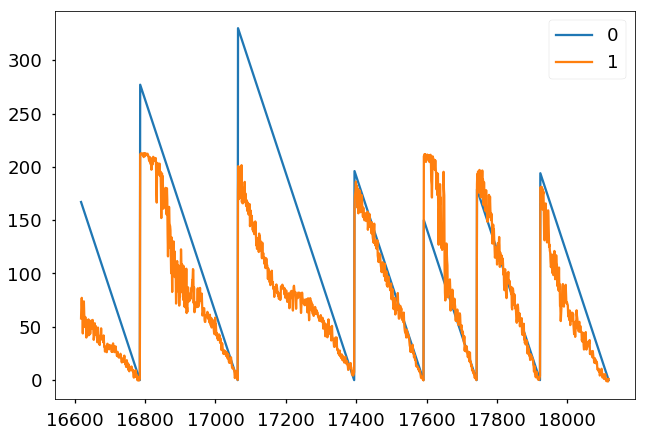

In [35]:
pd.DataFrame([label_array2,y_pred]).transpose()[-1500:].plot()

In [31]:
def rnn_cell_sig(hprev, xt, Wh, Wx, bh):
    return tf.sigmoid(tf.matmul(hprev, Wh) + tf.matmul(xt, Wx) + bh)

def rnn_cell_tanh(hprev, xt, Wh, Wx, bh):
    return tf.tanh(tf.matmul(hprev, Wh) + tf.matmul(xt, Wx) + bh)

In [91]:
def rnn_layer(X, Wh, Wx, bh, Wy, by, H):
    N, sequence_length, D = X.get_shape().as_list()
    h = tf.zeros([N,H])
    for i in range(sequence_length):
        h = rnn_cell_tanh(h,tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wh, Wx, bh)
    return tf.reshape(tf.matmul(h, Wy) + by,[-1])

# def rnn_cell(hprev, xt):
#     return tf.tanh(tf.matmul(hprev, Wh) + tf.matmul(xt, Wx) + bh)

# def rnn_layer(X, Wh, Wx, bh, Wy, by, H):
#     sequence_length, N, D = X.get_shape().as_list()
#     h = tf.scan(rnn_cell, X, initializer=tf.truncated_normal([N,H],mean=0.,stddev=0.1))
#     h = tf.squeeze(tf.slice(h,[sequence_length-1,0,0],[1,N,H]))
#     y = tf.reshape(tf.nn.softplus(tf.matmul(h, Wy) + by),[-1])
#     return y

Wh = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Wx = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wy = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]))
bh = Normal(loc=tf.zeros(H), scale=tf.ones(H))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
# X = tf.placeholder(tf.float32,[sequence_length,N,D])
y = Normal(loc=rnn_layer(X, Wh, Wx, bh, Wy, by, H), scale=1.)

## BBVI

In [92]:
# BACKWARD MODEL A
q_Wh = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Wx = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wy = Normal(loc=tf.Variable(tf.random_normal([H, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, 1]))))
q_bh = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [93]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wh: q_Wh, bh: q_bh,
                                 Wx: q_Wx, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=5, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 166s | Loss: 583062.438


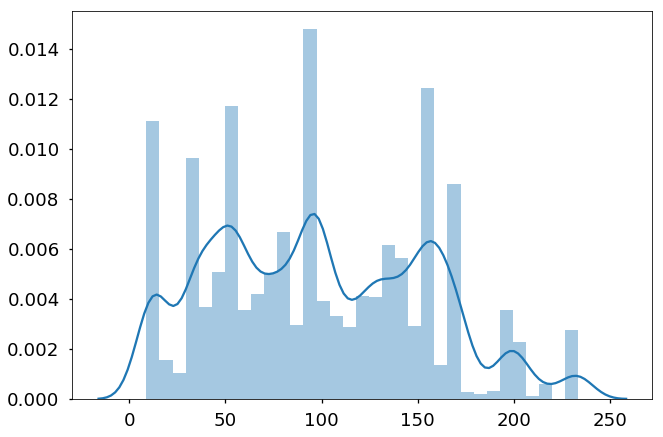

In [94]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_pred = sess.run(rnn_layer(Xp, q_Wh, q_Wx, q_bh, q_Wy, q_by, H),{Xp:seq_array2})
sns.distplot(y_pred)

In [95]:
np.sqrt(mean_squared_error(label_array2,y_pred))

40.790833

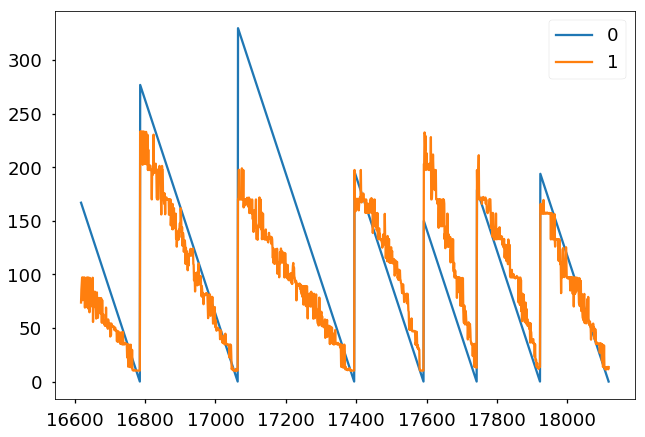

In [96]:
pd.DataFrame([label_array2,y_pred]).transpose()[-1500:].plot()

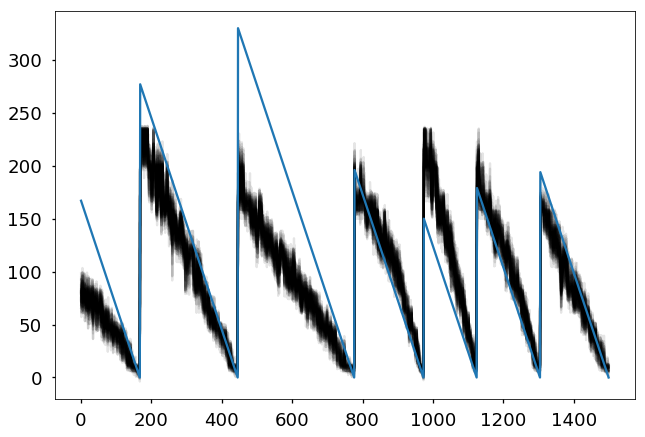

In [97]:
[plt.plot(sess.run(rnn_layer(Xp, q_Wh, q_Wx, q_bh, q_Wy, q_by, H),{Xp:seq_array2})[-1500:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-1500:])

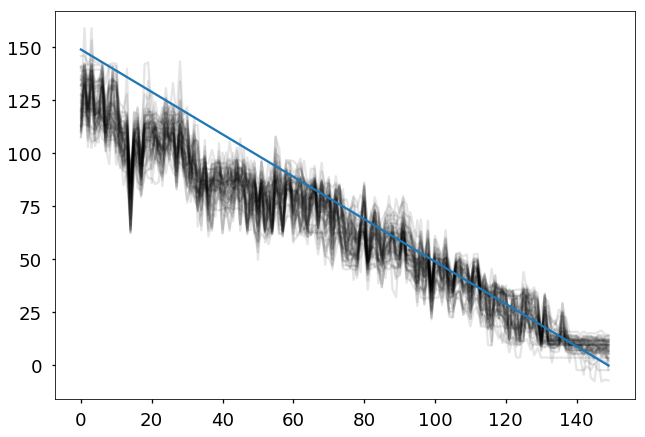

In [98]:
[plt.plot(sess.run(rnn_layer(Xp, q_Wh, q_Wx, q_bh, q_Wy, q_by, H),{Xp:seq_array2})[-150:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-150:])

## LSTM
-----------------

In [22]:
model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, D),
         units=H))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error'])
model.fit(seq_array1, label_array1, epochs=300, batch_size=200, 
          validation_data=(seq_array2,label_array2), verbose=1)

Train on 2013 samples, validate on 18118 samples
Epoch 1/300
2013/2013 [==============================] - 2s 848us/step - loss: 16285.2288 - mean_squared_error: 16285.2288 - val_loss: 13907.6125 - val_mean_squared_error: 13907.6125
Epoch 2/300
2013/2013 [==============================] - 0s 233us/step - loss: 14054.4164 - mean_squared_error: 14054.4164 - val_loss: 12462.8250 - val_mean_squared_error: 12462.8250
Epoch 3/300
2013/2013 [==============================] - 0s 227us/step - loss: 13226.9468 - mean_squared_error: 13226.9468 - val_loss: 11990.0419 - val_mean_squared_error: 11990.0419
Epoch 4/300
2013/2013 [==============================] - 0s 235us/step - loss: 12746.9047 - mean_squared_error: 12746.9047 - val_loss: 11567.0976 - val_mean_squared_error: 11567.0976
Epoch 5/300
2013/2013 [==============================] - 0s 240us/step - loss: 12307.1025 - mean_squared_error: 12307.1025 - val_loss: 11160.8203 - val_mean_squared_error: 11160.8203
Epoch 6/300
2013/2013 [=============

2013/2013 [==============================] - 0s 233us/step - loss: 4501.8325 - mean_squared_error: 4501.8325 - val_loss: 4599.1011 - val_mean_squared_error: 4599.1011
Epoch 92/300
2013/2013 [==============================] - 0s 226us/step - loss: 4501.3691 - mean_squared_error: 4501.3691 - val_loss: 4600.3485 - val_mean_squared_error: 4600.3485
Epoch 93/300
2013/2013 [==============================] - 0s 235us/step - loss: 4500.8975 - mean_squared_error: 4500.8975 - val_loss: 4601.9496 - val_mean_squared_error: 4601.9496
Epoch 94/300
2013/2013 [==============================] - 0s 228us/step - loss: 4500.2781 - mean_squared_error: 4500.2781 - val_loss: 4603.2494 - val_mean_squared_error: 4603.2494
Epoch 95/300
2013/2013 [==============================] - 0s 233us/step - loss: 4499.9300 - mean_squared_error: 4499.9300 - val_loss: 4604.6488 - val_mean_squared_error: 4604.6488
Epoch 96/300
2013/2013 [==============================] - 0s 233us/step - loss: 4499.5288 - mean_squared_error: 4

2013/2013 [==============================] - 1s 258us/step - loss: 1114.4564 - mean_squared_error: 1114.4564 - val_loss: 1883.8538 - val_mean_squared_error: 1883.8538
Epoch 182/300
2013/2013 [==============================] - 1s 264us/step - loss: 1089.7263 - mean_squared_error: 1089.7263 - val_loss: 2434.5047 - val_mean_squared_error: 2434.5047
Epoch 183/300
2013/2013 [==============================] - 1s 256us/step - loss: 1097.4769 - mean_squared_error: 1097.4769 - val_loss: 1694.8062 - val_mean_squared_error: 1694.8062
Epoch 184/300
2013/2013 [==============================] - 0s 246us/step - loss: 1067.9443 - mean_squared_error: 1067.9443 - val_loss: 1988.7104 - val_mean_squared_error: 1988.7104
Epoch 185/300
2013/2013 [==============================] - 1s 253us/step - loss: 1047.3833 - mean_squared_error: 1047.3833 - val_loss: 1931.1938 - val_mean_squared_error: 1931.1938
Epoch 186/300
2013/2013 [==============================] - 1s 266us/step - loss: 1009.5389 - mean_squared_err

Epoch 227/300
2013/2013 [==============================] - 0s 235us/step - loss: 560.1387 - mean_squared_error: 560.1387 - val_loss: 1632.7485 - val_mean_squared_error: 1632.7485
Epoch 228/300
2013/2013 [==============================] - 0s 239us/step - loss: 597.7202 - mean_squared_error: 597.7202 - val_loss: 1681.5939 - val_mean_squared_error: 1681.5939
Epoch 229/300
2013/2013 [==============================] - 0s 235us/step - loss: 548.9265 - mean_squared_error: 548.9265 - val_loss: 1467.6313 - val_mean_squared_error: 1467.6313
Epoch 230/300
2013/2013 [==============================] - 0s 234us/step - loss: 582.1299 - mean_squared_error: 582.1299 - val_loss: 1831.8615 - val_mean_squared_error: 1831.8615
Epoch 231/300
2013/2013 [==============================] - 0s 229us/step - loss: 539.4852 - mean_squared_error: 539.4852 - val_loss: 1642.3885 - val_mean_squared_error: 1642.3885
Epoch 232/300
2013/2013 [==============================] - 0s 239us/step - loss: 525.1889 - mean_squared_

Epoch 273/300
2013/2013 [==============================] - 0s 242us/step - loss: 376.6211 - mean_squared_error: 376.6211 - val_loss: 1804.2463 - val_mean_squared_error: 1804.2463
Epoch 274/300
2013/2013 [==============================] - 0s 243us/step - loss: 375.5278 - mean_squared_error: 375.5278 - val_loss: 1930.7733 - val_mean_squared_error: 1930.7733
Epoch 275/300
2013/2013 [==============================] - 0s 237us/step - loss: 368.7426 - mean_squared_error: 368.7426 - val_loss: 1815.4850 - val_mean_squared_error: 1815.4850
Epoch 276/300
2013/2013 [==============================] - 0s 241us/step - loss: 385.6941 - mean_squared_error: 385.6941 - val_loss: 2261.1757 - val_mean_squared_error: 2261.1757
Epoch 277/300
2013/2013 [==============================] - 0s 240us/step - loss: 416.7837 - mean_squared_error: 416.7837 - val_loss: 1909.0057 - val_mean_squared_error: 1909.0057
Epoch 278/300
2013/2013 [==============================] - 0s 241us/step - loss: 353.8959 - mean_squared_

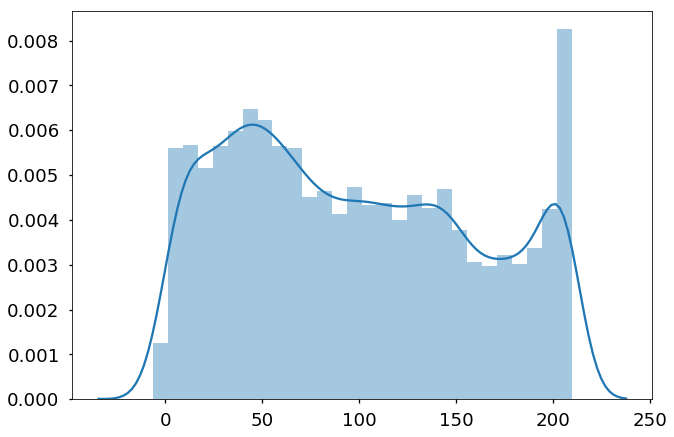

In [23]:
y_pred = np.squeeze(model.predict(seq_array2))
sns.distplot(y_pred)

In [24]:
np.sqrt(mean_squared_error(label_array2,y_pred))

40.825169

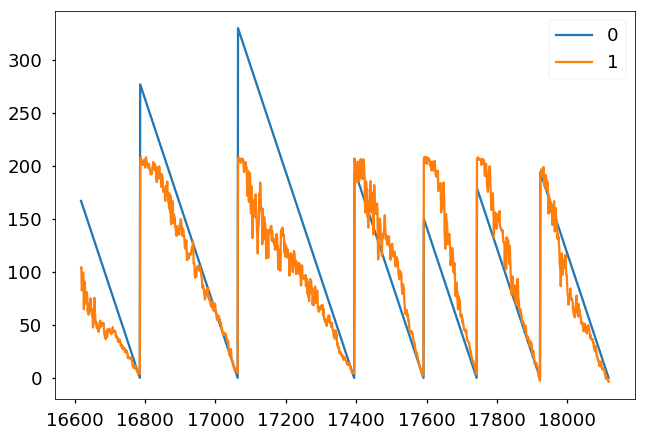

In [25]:
pd.DataFrame([label_array2,y_pred]).transpose()[-1500:].plot()

In [99]:
def LSTM_cell(hprev, cprev, xt, Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc):
    f = rnn_cell_sig(hprev,xt,Wf,Uf,bf)
    i = rnn_cell_sig(hprev,xt,Wi,Ui,bi)
    o = rnn_cell_sig(hprev,xt,Wo,Uo,bo)
    c = f*cprev + i*rnn_cell_tanh(hprev,xt,Wc,Uc,bc)
    h = o*tf.tanh(c)
    return h,c

def LSTM_layer(X, Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc, Wy, by, H):
    N, sequence_length, D = X.get_shape().as_list()
    h = tf.zeros([N,H])
    c = tf.zeros([N,H])
    for i in range(sequence_length):
        h,c = LSTM_cell(h, c, tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc)
    return tf.reshape(tf.matmul(h, Wy) + by,[-1])


Wf = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uf = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wi = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Ui = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wo = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uo = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wc = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uc = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wy = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]))
bf = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bi = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bo = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bc = Normal(loc=tf.zeros(H), scale=tf.ones(H))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
y = Normal(loc=LSTM_layer(X, Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc, Wy, by, H), scale=1.)

## BBVI

In [100]:
# BACKWARD MODEL A
q_Wf = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uf = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wi = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Ui = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wo = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uo = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wc = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uc = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wy = Normal(loc=tf.Variable(tf.random_normal([H, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, 1]))))
q_bf = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bi = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bo = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bc = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [101]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wf: q_Wf, Uf: q_Uf, Wi: q_Wi, Ui: q_Ui, Wo: q_Wo, Uo: q_Uo, Wc: q_Wc, Uc: q_Uc,
                                 bf: q_bf, bi: q_bi, bo: q_bo, bc: q_bc, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=5, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 748s | Loss: 198785.250


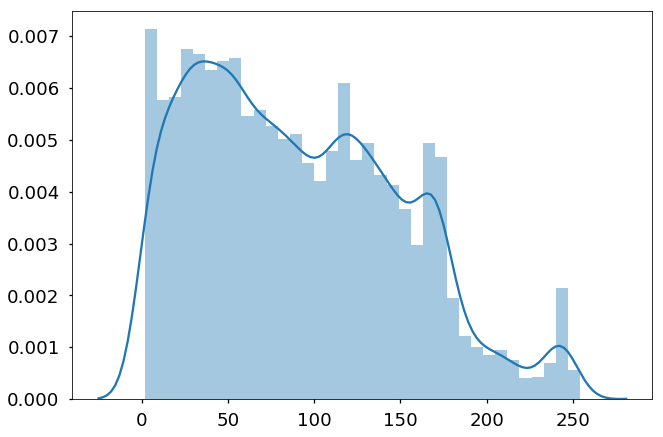

In [102]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_pred = sess.run(LSTM_layer(Xp, q_Wf, q_Uf, q_Wi, q_Ui, q_Wo, q_Uo, q_Wc, q_Uc, 
                             q_bf, q_bi, q_bo, q_bc, q_Wy, q_by, H),{Xp:seq_array2})
sns.distplot(y_pred)

In [103]:
np.sqrt(mean_squared_error(label_array2,y_pred))

43.807281

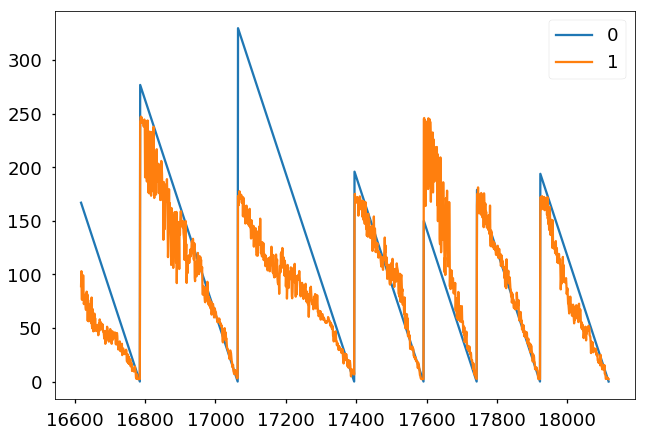

In [104]:
pd.DataFrame([label_array2,y_pred]).transpose()[-1500:].plot()

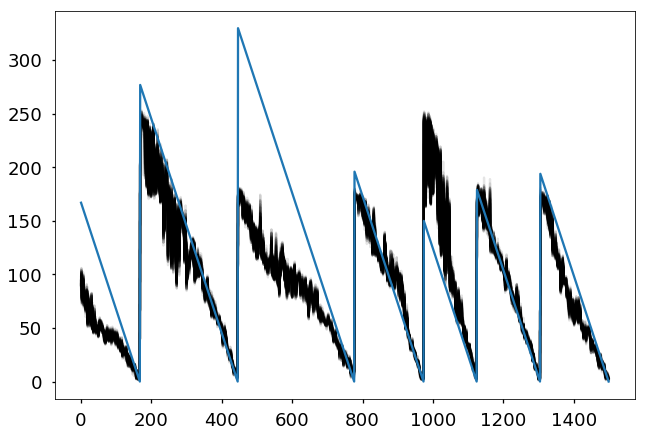

In [109]:
[plt.plot(sess.run(LSTM_layer(Xp, q_Wf, q_Uf, q_Wi, q_Ui, q_Wo, q_Uo, q_Wc, q_Uc, 
                             q_bf, q_bi, q_bo, q_bc, q_Wy, q_by, H),{Xp:seq_array2})[-1500:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-1500:])

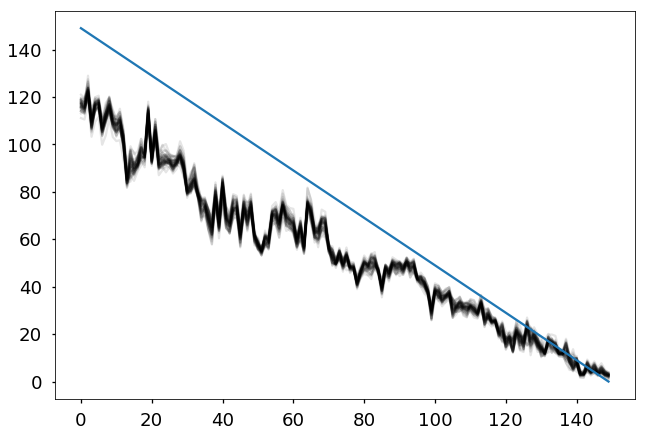

In [110]:
[plt.plot(sess.run(LSTM_layer(Xp, q_Wf, q_Uf, q_Wi, q_Ui, q_Wo, q_Uo, q_Wc, q_Uc, 
                             q_bf, q_bi, q_bo, q_bc, q_Wy, q_by, H),{Xp:seq_array2})[-150:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-150:])

## GRU
-----------------

In [26]:
model = Sequential()

model.add(GRU(
         input_shape=(sequence_length, D),
         units=H))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error'])
model.fit(seq_array1, label_array1, epochs=300, batch_size=200, 
          validation_data=(seq_array2,label_array2), verbose=1)

Train on 2013 samples, validate on 18118 samples
Epoch 1/300
2013/2013 [==============================] - 1s 528us/step - loss: 16119.5439 - mean_squared_error: 16119.5439 - val_loss: 13320.1797 - val_mean_squared_error: 13320.1797
Epoch 2/300
2013/2013 [==============================] - 0s 210us/step - loss: 13843.3410 - mean_squared_error: 13843.3410 - val_loss: 12463.9645 - val_mean_squared_error: 12463.9645
Epoch 3/300
2013/2013 [==============================] - 0s 206us/step - loss: 13234.4221 - mean_squared_error: 13234.4221 - val_loss: 12000.0162 - val_mean_squared_error: 12000.0162
Epoch 4/300
2013/2013 [==============================] - 1s 265us/step - loss: 12761.2492 - mean_squared_error: 12761.2492 - val_loss: 11583.3053 - val_mean_squared_error: 11583.3053
Epoch 5/300
2013/2013 [==============================] - 0s 199us/step - loss: 12328.6100 - mean_squared_error: 12328.6100 - val_loss: 11190.2555 - val_mean_squared_error: 11190.2555
Epoch 6/300
2013/2013 [=============

2013/2013 [==============================] - 0s 200us/step - loss: 4501.9599 - mean_squared_error: 4501.9599 - val_loss: 4598.6105 - val_mean_squared_error: 4598.6105
Epoch 92/300
2013/2013 [==============================] - 0s 192us/step - loss: 4501.3946 - mean_squared_error: 4501.3946 - val_loss: 4599.3689 - val_mean_squared_error: 4599.3689
Epoch 93/300
2013/2013 [==============================] - 0s 205us/step - loss: 4501.1343 - mean_squared_error: 4501.1343 - val_loss: 4600.2224 - val_mean_squared_error: 4600.2224
Epoch 94/300
2013/2013 [==============================] - 0s 198us/step - loss: 4500.7149 - mean_squared_error: 4500.7149 - val_loss: 4601.7401 - val_mean_squared_error: 4601.7401
Epoch 95/300
2013/2013 [==============================] - 0s 196us/step - loss: 4500.1009 - mean_squared_error: 4500.1009 - val_loss: 4603.4328 - val_mean_squared_error: 4603.4328
Epoch 96/300
2013/2013 [==============================] - 0s 198us/step - loss: 4499.5706 - mean_squared_error: 4

2013/2013 [==============================] - 0s 221us/step - loss: 984.5059 - mean_squared_error: 984.5059 - val_loss: 1683.7967 - val_mean_squared_error: 1683.7967
Epoch 182/300
2013/2013 [==============================] - 0s 192us/step - loss: 1006.3732 - mean_squared_error: 1006.3732 - val_loss: 1770.3492 - val_mean_squared_error: 1770.3492
Epoch 183/300
2013/2013 [==============================] - 0s 198us/step - loss: 942.5802 - mean_squared_error: 942.5802 - val_loss: 1949.9314 - val_mean_squared_error: 1949.9314
Epoch 184/300
2013/2013 [==============================] - 0s 192us/step - loss: 923.9911 - mean_squared_error: 923.9911 - val_loss: 1622.7818 - val_mean_squared_error: 1622.7818
Epoch 185/300
2013/2013 [==============================] - 0s 194us/step - loss: 965.6892 - mean_squared_error: 965.6892 - val_loss: 1758.6692 - val_mean_squared_error: 1758.6692
Epoch 186/300
2013/2013 [==============================] - 0s 201us/step - loss: 902.9830 - mean_squared_error: 902.9

Epoch 227/300
2013/2013 [==============================] - 0s 203us/step - loss: 541.2901 - mean_squared_error: 541.2901 - val_loss: 1726.7531 - val_mean_squared_error: 1726.7531
Epoch 228/300
2013/2013 [==============================] - 0s 200us/step - loss: 554.4734 - mean_squared_error: 554.4734 - val_loss: 1670.6860 - val_mean_squared_error: 1670.6860
Epoch 229/300
2013/2013 [==============================] - 0s 195us/step - loss: 545.1738 - mean_squared_error: 545.1738 - val_loss: 1805.4248 - val_mean_squared_error: 1805.4248
Epoch 230/300
2013/2013 [==============================] - 0s 202us/step - loss: 521.8761 - mean_squared_error: 521.8761 - val_loss: 1719.4038 - val_mean_squared_error: 1719.4038
Epoch 231/300
2013/2013 [==============================] - 0s 196us/step - loss: 527.6669 - mean_squared_error: 527.6669 - val_loss: 2479.8067 - val_mean_squared_error: 2479.8067
Epoch 232/300
2013/2013 [==============================] - 0s 201us/step - loss: 609.8770 - mean_squared_

Epoch 273/300
2013/2013 [==============================] - 0s 223us/step - loss: 389.9125 - mean_squared_error: 389.9125 - val_loss: 1810.3224 - val_mean_squared_error: 1810.3224
Epoch 274/300
2013/2013 [==============================] - 0s 197us/step - loss: 404.6053 - mean_squared_error: 404.6053 - val_loss: 1819.9904 - val_mean_squared_error: 1819.9904
Epoch 275/300
2013/2013 [==============================] - 0s 195us/step - loss: 395.0638 - mean_squared_error: 395.0638 - val_loss: 2158.8971 - val_mean_squared_error: 2158.8971
Epoch 276/300
2013/2013 [==============================] - 0s 196us/step - loss: 405.6159 - mean_squared_error: 405.6159 - val_loss: 1786.6910 - val_mean_squared_error: 1786.6910
Epoch 277/300
2013/2013 [==============================] - 0s 215us/step - loss: 408.1974 - mean_squared_error: 408.1974 - val_loss: 1630.8345 - val_mean_squared_error: 1630.8345
Epoch 278/300
2013/2013 [==============================] - 0s 191us/step - loss: 371.7895 - mean_squared_

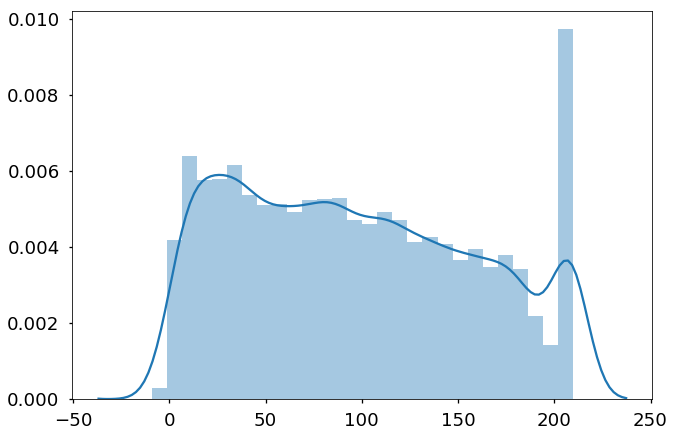

In [27]:
y_pred = np.squeeze(model.predict(seq_array2))
sns.distplot(y_pred)

In [28]:
np.sqrt(mean_squared_error(label_array2,y_pred))

41.604958

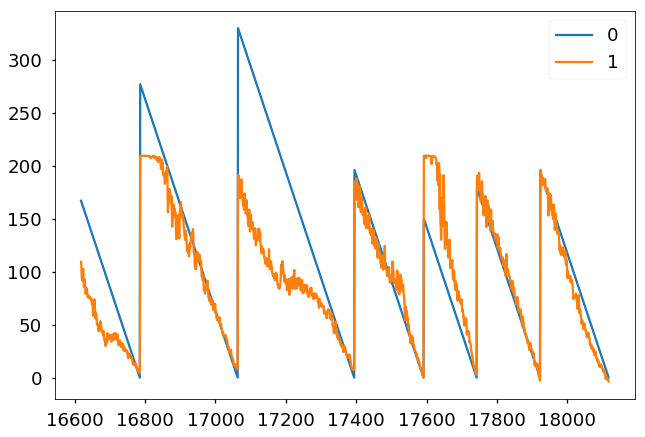

In [29]:
pd.DataFrame([label_array2,y_pred]).transpose()[-1500:].plot()

In [111]:
def GRU_cell(hprev, xt, Wz, Uz, Wr, Ur, Wh, Uh, bz, br, bh):
    z = rnn_cell_sig(hprev,xt,Wz,Uz,bz)
    r = rnn_cell_sig(hprev,xt,Wr,Ur,br)
    h = z*hprev + (1-z)*rnn_cell_tanh(r*hprev,xt,Wh,Uh,bh)
    return h

def GRU_layer(X, Wz, Uz, Wr, Ur, Wh, Uh, bz, br, bh, Wy, by, H):
    N, sequence_length, D = X.get_shape().as_list()
    h = tf.zeros([N,H])
    for i in range(sequence_length):
        h = GRU_cell(h, tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wz, Uz, Wr, Ur, Wh, Uh, bz, br, bh)
    return tf.reshape(tf.matmul(h, Wy) + by,[-1])


Wz = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uz = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wr = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Ur = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wh = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uh = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wy = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]))
bz = Normal(loc=tf.zeros(H), scale=tf.ones(H))
br = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bh = Normal(loc=tf.zeros(H), scale=tf.ones(H))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
y = Normal(loc=GRU_layer(X, Wz, Uz, Wr, Ur, Wh, Uh, bz, br, bh, Wy, by, H), scale=1.)

## BBVI

In [112]:
# BACKWARD MODEL A
q_Wz = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uz = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wr = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Ur = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wh = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uh = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wy = Normal(loc=tf.Variable(tf.random_normal([H, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, 1]))))
q_bz = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_br = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bh = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [113]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wz: q_Wz, Uz: q_Uz, Wr: q_Wr, Ur: q_Ur, Wh: q_Wh, Uh: q_Uh,
                                 bz: q_bz, bz: q_bz, bh: q_bh, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=5, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 524s | Loss: 283313.594


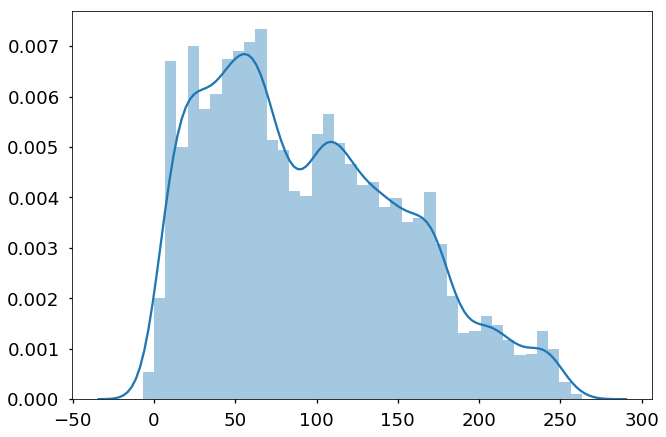

In [114]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_pred = sess.run(GRU_layer(Xp, q_Wz, q_Uz, q_Wr, q_Ur, q_Wh, q_Uh, 
                            q_bz, q_br, q_bh, q_Wy, q_by, H),{Xp:seq_array2})
sns.distplot(y_pred)

In [115]:
np.sqrt(mean_squared_error(label_array2,y_pred))

43.350227

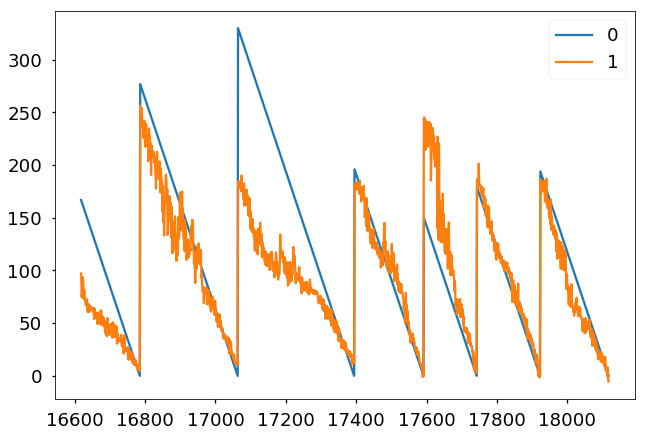

In [116]:
pd.DataFrame([label_array2,y_pred]).transpose()[-1500:].plot()

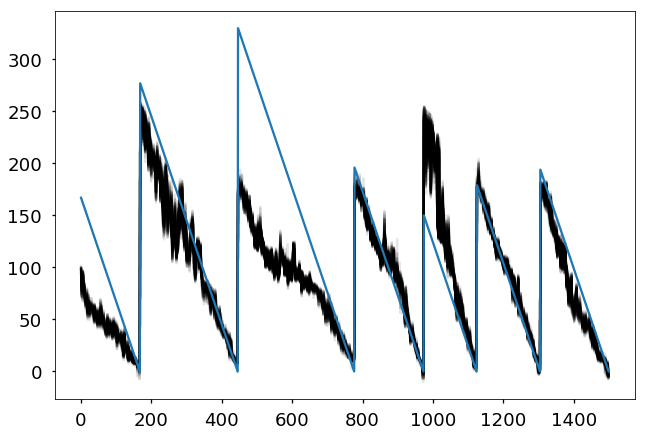

In [117]:
[plt.plot(sess.run(GRU_layer(Xp, q_Wz, q_Uz, q_Wr, q_Ur, q_Wh, q_Uh, 
                            q_bz, q_br, q_bh, q_Wy, q_by, H),{Xp:seq_array2})[-1500:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-1500:])

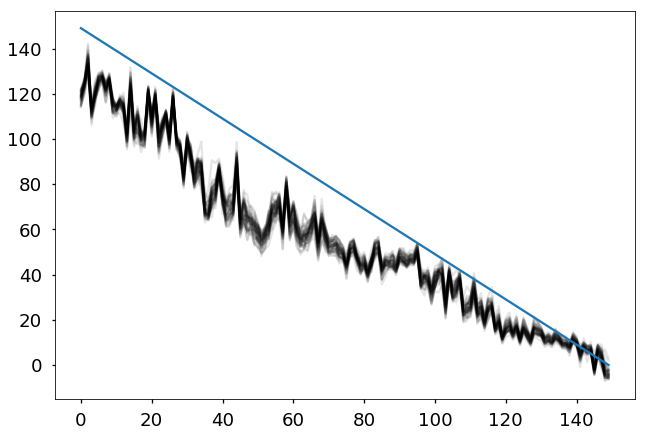

In [118]:
[plt.plot(sess.run(GRU_layer(Xp, q_Wz, q_Uz, q_Wr, q_Ur, q_Wh, q_Uh, 
                            q_bz, q_br, q_bh, q_Wy, q_by, H),{Xp:seq_array2})[-150:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-150:])